## Project Description

The objective of this project was to analyze a network using the techniques learned during the course.

The network used for this project is the global network of migration between countries, collected by the United Nations. A directed edge gives the flow of migration, and an edge property gives the number of migrants, for each given year and sex. Estimates are presented for 1990, 1995, 2000, 2005, 2010 and 2015 and are available for all countries and areas of the world. 

To streamline the analysis, the data spanning from 1990 to 2015 was aggregated into a single figure for each country, combining all years and genders. 

The data was gathered from https://networks.skewed.de/net/un_migrations.

## Project setup (packages, options, etc.)

In [ ]:
!pip3 install -r requirements.txt

In [161]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mplt
import numpy as np
import seaborn as sns
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import rand_score
import itertools

In [213]:
NET_SEED = 8
np.seterr(divide = 'ignore') 

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Data cleaning, graph creation and initial analysis and visualization

In [163]:
g = nx.DiGraph()

In [164]:
nodes = pd.read_csv("../data/nodes.csv")
nodes.drop(nodes.columns[[0, 5]], axis = 1, inplace = True)
nodes.replace(to_replace = ["United Kingdom of Great Britain and Northern Ireland", "United States of America", "Russian Federation"], value = ["UK", "USA", "Russian Fed."], inplace = True)
nodes.columns = nodes.columns.str.lstrip()
rows_as_dicts = nodes.to_dict('index')
nodes

,name,code,region,sub_region
0,Afghanistan,4,Asia,Southern Asia
1,Albania,8,Europe,Southern Europe
2,Algeria,12,Africa,Northern Africa
3,American Samoa,16,Oceania,Polynesia
4,Andorra,20,Europe,Southern Europe
...,...,...,...,...
227,Wallis and Futuna Islands,876,Oceania,Polynesia
228,Western Sahara,732,Africa,Northern Africa
229,Yemen,887,Asia,Western Asia
230,Zambia,894,Africa,Eastern Africa


In [165]:
for i, attrs in rows_as_dicts.items():
    g.add_node(i, **attrs)

In [166]:
edges = pd.read_csv("../data/edges.csv")
edges.rename(columns = {edges.columns[0]: 'source'}, inplace = True)
edges.columns = edges.columns.str.lstrip()
edges["migration_total"] = edges.filter(like = "total").sum(axis = 1)
edges = edges.set_index(['source', 'target'])
edges

migration_1990_total  migration_1990_male  \
source target                                              
0      64                       237                  194   
       118                      677                  556   
       142                       64                   26   
       191                       59                   37   
       202                     8485                 3726   
...                             ...                  ...   
231    220                     4767                 2148   
       11                      8265                 4184   
       147                      676                  323   
       68                         0                    0   
       28                         0                    0   

               migration_1990_female  migration_1995_total  \
source target                                                
0      64                         43                   188   
       118                       121                   452   
       142                        38                    61   
       191                        22                    36   
       202                      4759                 12248   
...                              ...                   ...   
231    220                      2619                  7571   
       11                       4081                 10498   
       147                       353                   822   
       68                          0                     0   
       28                          0                     0   

               migration_1995_male  migration_1995_female  \
source target                                               
0      64                      150                     38   
       118                     351                    101   
       142                      25                     36   
       191                      24                     12   
       202                    5518                   6730   
...                            ...                    ...   
231    220                    3451                   4120   
       11                     5291                   5207   
       147                     398                    424   
       68                        0                      0   
       28                        0                      0   

               migration_2000_total  migration_2000_male  \
source target                                              
0      64                       154                  117   
       118                      236                  155   
       142                       58                   23   
       191                       30                   20   
       202                    17118                 7874   
...                             ...                  ...   
231    220                    10686                 4909   
       11                     12110                 6110   
       147                     2807                 1365   
       68                         0                    0   
       28                         0                    0   

               migration_2000_female  migration_2005_total  \
source target                                                
0      64                         37                   183   
       118                        81                   259   
       142                        35                    45   
       191                        10                    47   
       202                      9244                 12636   
...                              ...                   ...   
231    220                      5777                 26585   
       11                       6000                 21690   
       147                      1442                  7794   
       68                          0                     0   
       28                          0                     0   

               migration_2005_male  migration

In [167]:
for i, attrs in edges.to_dict('index').items():
    g.add_edge(*i, **attrs)

In [168]:
unique_regions = set(nx.get_node_attributes(g, 'region').values())
color_map = {region: plt.cm.tab20(i) for i, region in enumerate(unique_regions)}
node_colors = [color_map[g.nodes[node]['region']] for node in g.nodes()]

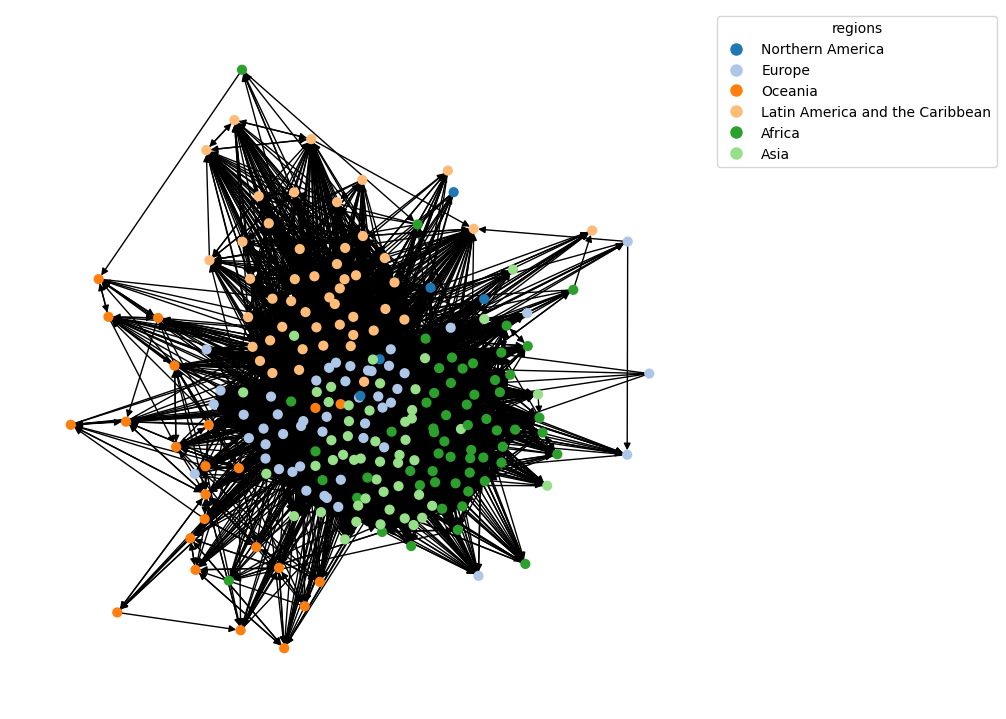

In [169]:
plt.figure(figsize = (7, 7))
nx.draw(g, node_color = node_colors, with_labels = False, node_size = 40, pos = nx.spring_layout(g, seed = NET_SEED))
region_patches = [plt.Line2D([0], [0], marker = 'o', color = 'w', label = region,
                          markerfacecolor = color, markersize = 10)
                     for region, color in color_map.items()]
plt.legend(handles = region_patches, title = "regions", loc = 'upper left', bbox_to_anchor = (1, 1))

plt.show()

In [170]:
nn = nx.number_of_nodes(g)
ne = nx.number_of_edges(g)
print("Number of nodes:", nn)
print("Number of edges:", ne)

Number of nodes: 232
Number of edges: 11228


In [171]:
density = nx.density(g)
weakly_connected = nx.is_weakly_connected(g)
strongly_connected = nx.is_strongly_connected(g)

print("Density:", density)
print("The graph", "is" if weakly_connected else "isn't" , "weakly connected")
print("The graph", "is" if strongly_connected else "isn't" , "strongly connected")

Density: 0.20950888192267503
The graph is weakly connected
The graph isn't strongly connected


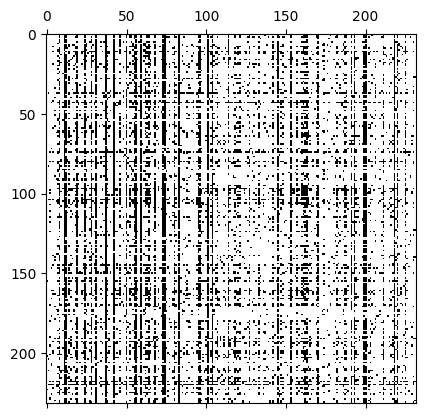

In [172]:
adj_matrix = nx.adjacency_matrix(g)
plt.spy(adj_matrix.todense())
plt.show()

## Centralities

In [173]:
centralities = {}

In [174]:
def display_centrality(g, centrality, key, ax = plt):
    vmin = min(centrality.values())
    vmax = max(centrality.values())
    norm = mplt.colors.Normalize(vmin = vmin, vmax = vmax)
    colors = [plt.cm.rainbow_r(norm(centrality[x])) for x in g.nodes]
    sm = plt.cm.ScalarMappable(cmap = plt.cm.rainbow_r, norm = norm)
    sm.set_array([])
    plt.colorbar(sm, orientation = 'vertical', ax = ax)
    nx.draw_networkx(g, pos = nx.spring_layout(g, seed = NET_SEED),  
                     ax =ax, node_size = np.interp(list(centrality.values()), (vmin, vmax), [30, 50]),
                     with_labels = False, node_color = colors)
    ax.set(title = f"{key} centrality")

### Freeman indices

In [175]:
centralities["In_degree"] = dict(g.in_degree())
centralities["Out_degree"] = dict(g.out_degree())
centralities["In_strength"] = dict(g.in_degree(weight = 'migration_total'))
centralities["Out_strength"] = dict(g.out_degree(weight = 'migration_total'))
centralities["Betweenness"] = nx.betweenness_centrality(g)
centralities["Closeness"] = nx.closeness_centrality(g)

#### Visualization of the indices on the graph

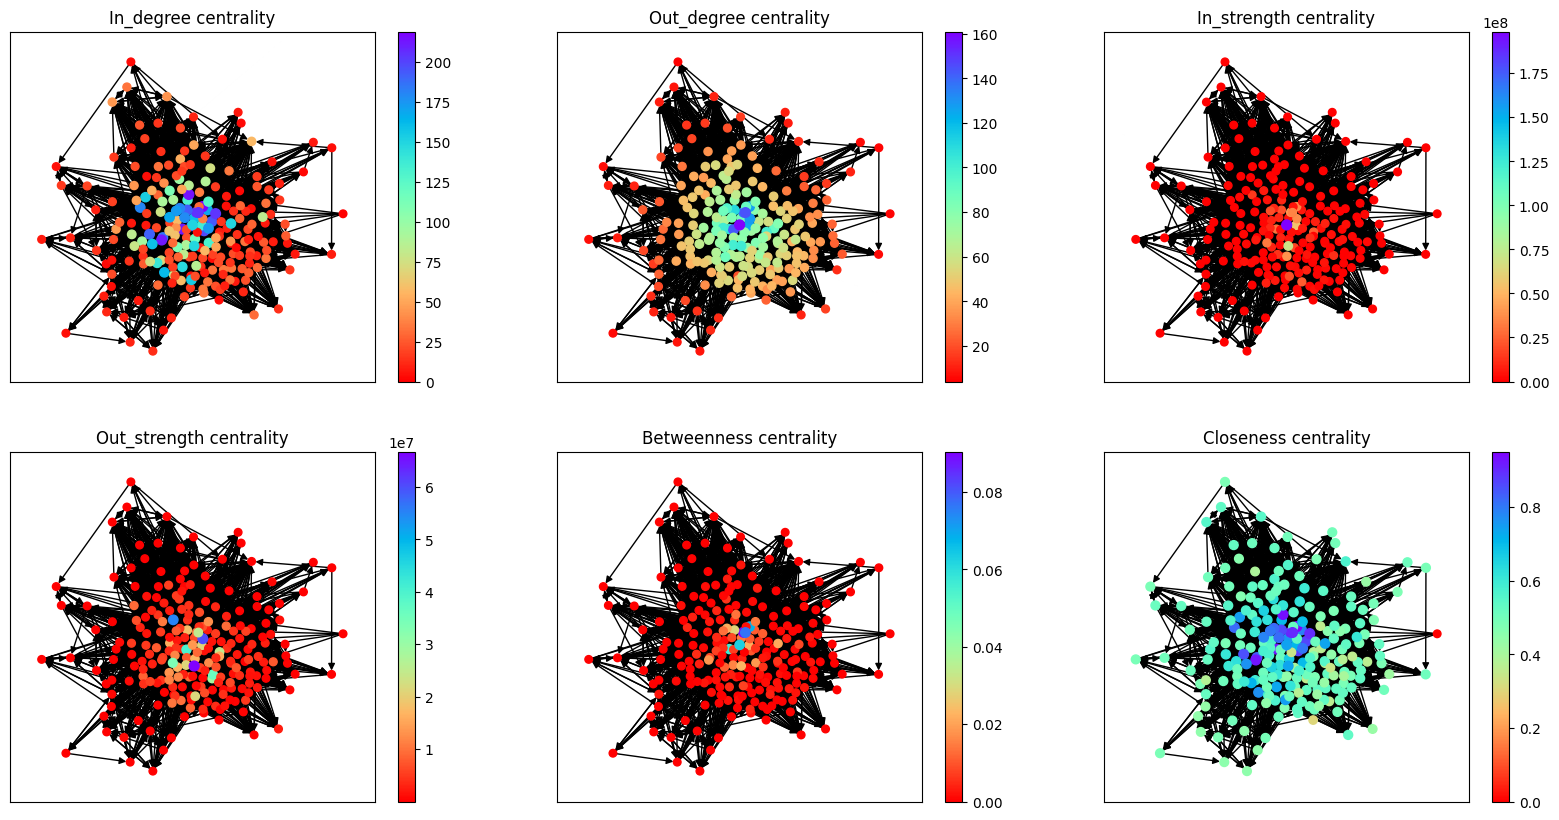

In [176]:
_, subp = plt.subplots(math.ceil(len(centralities) / 3), 3, figsize = (20, 10))
for idx, (k, v) in enumerate(centralities.items()):
    display_centrality(g, v, k, ax = subp[math.floor(idx / 3)][idx % 3])
plt.show()

#### Top countries for each index

In [177]:
def display_top(g, d, n, ax = plt, title = ""):
    sorted_d = sorted(d, key = lambda x : x[1], reverse = True)
    ax.bar([g.nodes[id].get("name") for id, _ in sorted_d[:n]], [value for _, value in sorted_d[:n]])
    ax.set(title = title)
    ax.tick_params(axis = 'x', labelrotation = 90)

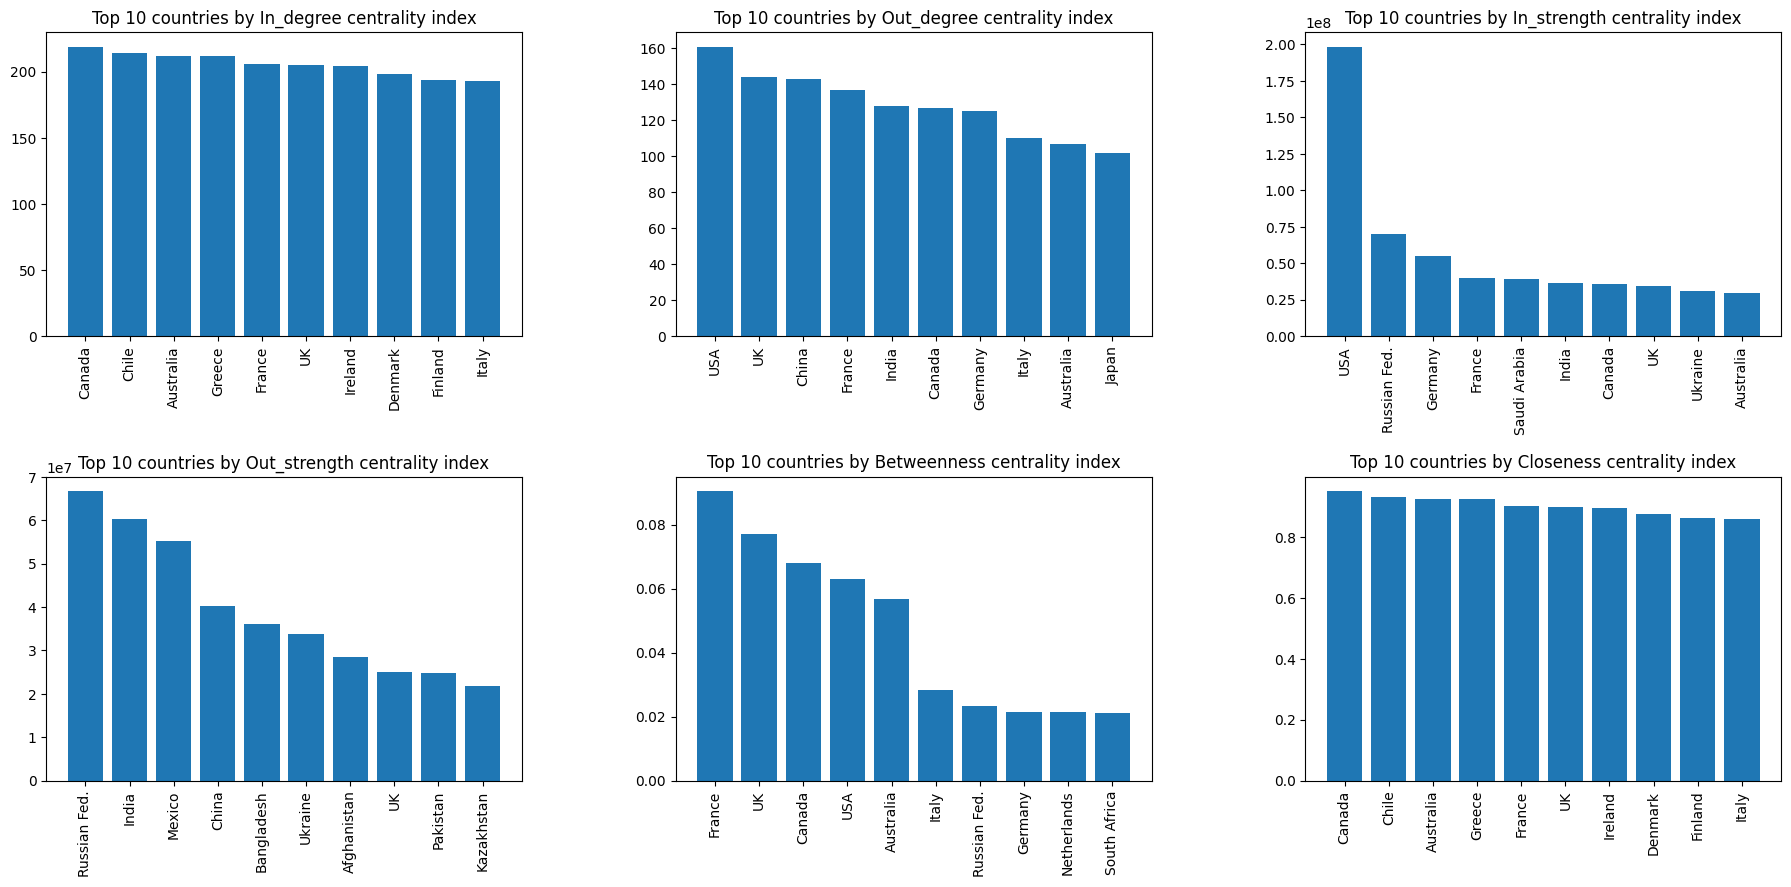

In [178]:
fig, subp = plt.subplots(math.ceil(len(centralities) / 3), 3, figsize = (20, 10))
fig.tight_layout(pad = 8.0)
for idx, key in enumerate(centralities.keys()):
    display_top(g, list(centralities[key].items()), 10, ax = subp[math.floor(idx / 3)][idx % 3], title = f"Top 10 countries by {key} centrality index")
plt.show()

In [211]:
def get_id(g, name):
    for node in g.nodes:
        if g.nodes[node].get("name") == name:
            return node
    return -1

In [212]:
top10russ = sorted(list(g.out_edges(get_id(g, "Russian Fed."))), key = lambda x: g.get_edge_data(*x)["migration_total"], reverse = True)[:10]
top10russ = [g.nodes[y].get("name") for x, y in top10russ]
top10russ

['Ukraine',
 'Kazakhstan',
 'Uzbekistan',
 'Germany',
 'Belarus',
 'USA',
 'Tajikistan',
 'Latvia',
 'Kyrgyzstan',
 'Estonia']

### Spectral indices

In [183]:
spectral_radius = 1 / max(nx.adjacency_spectrum(g, weight = 'migration_total')).real


In [184]:
centralities["Katz"] = nx.katz_centrality(g, alpha = 0.95 * spectral_radius, weight = 'migration_total')
centralities["Left_Eigenvector"] = nx.eigenvector_centrality(g.reverse(), weight = 'migration_total')
centralities["Right_Eigenvector"] = nx.eigenvector_centrality(g, weight = 'migration_total')
centralities["Hub"], centralities["Authority"] = nx.hits(g)
centralities["PageRank"] = nx.pagerank(g)

#### Visualization of the indices on the graph

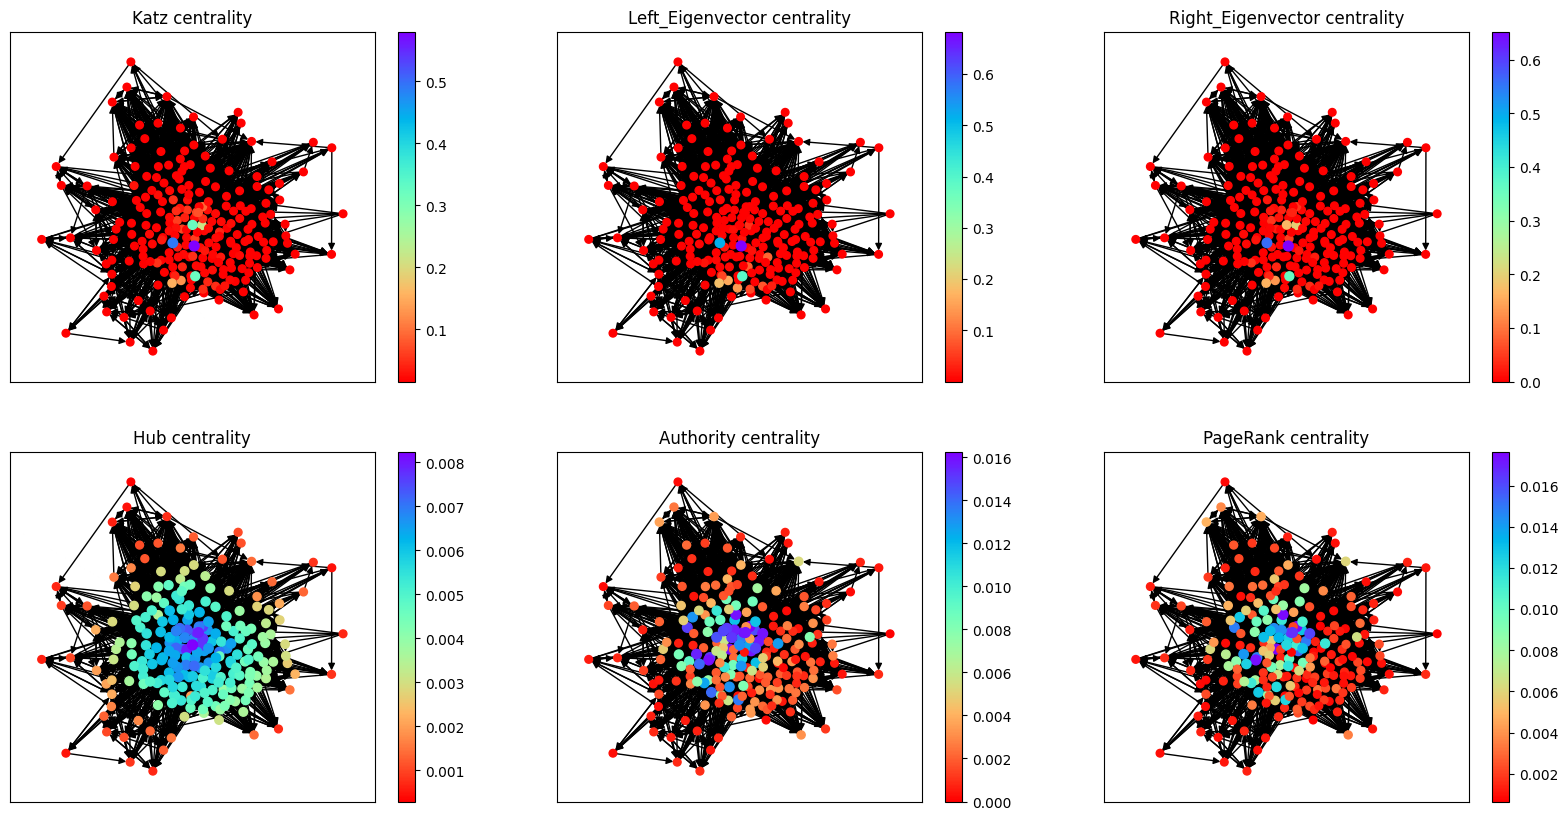

In [185]:
sp_indices = {k : v for (k, v) in list(centralities.items())[6:]}
_, subp = plt.subplots(math.ceil(len(sp_indices) / 3), 3, figsize = (20, 10))
for idx, (k, v) in enumerate(sp_indices.items()):
    display_centrality(g, v, k, ax = subp[math.floor(idx / 3)][idx % 3])
plt.show()

#### Top countries for each spectral index

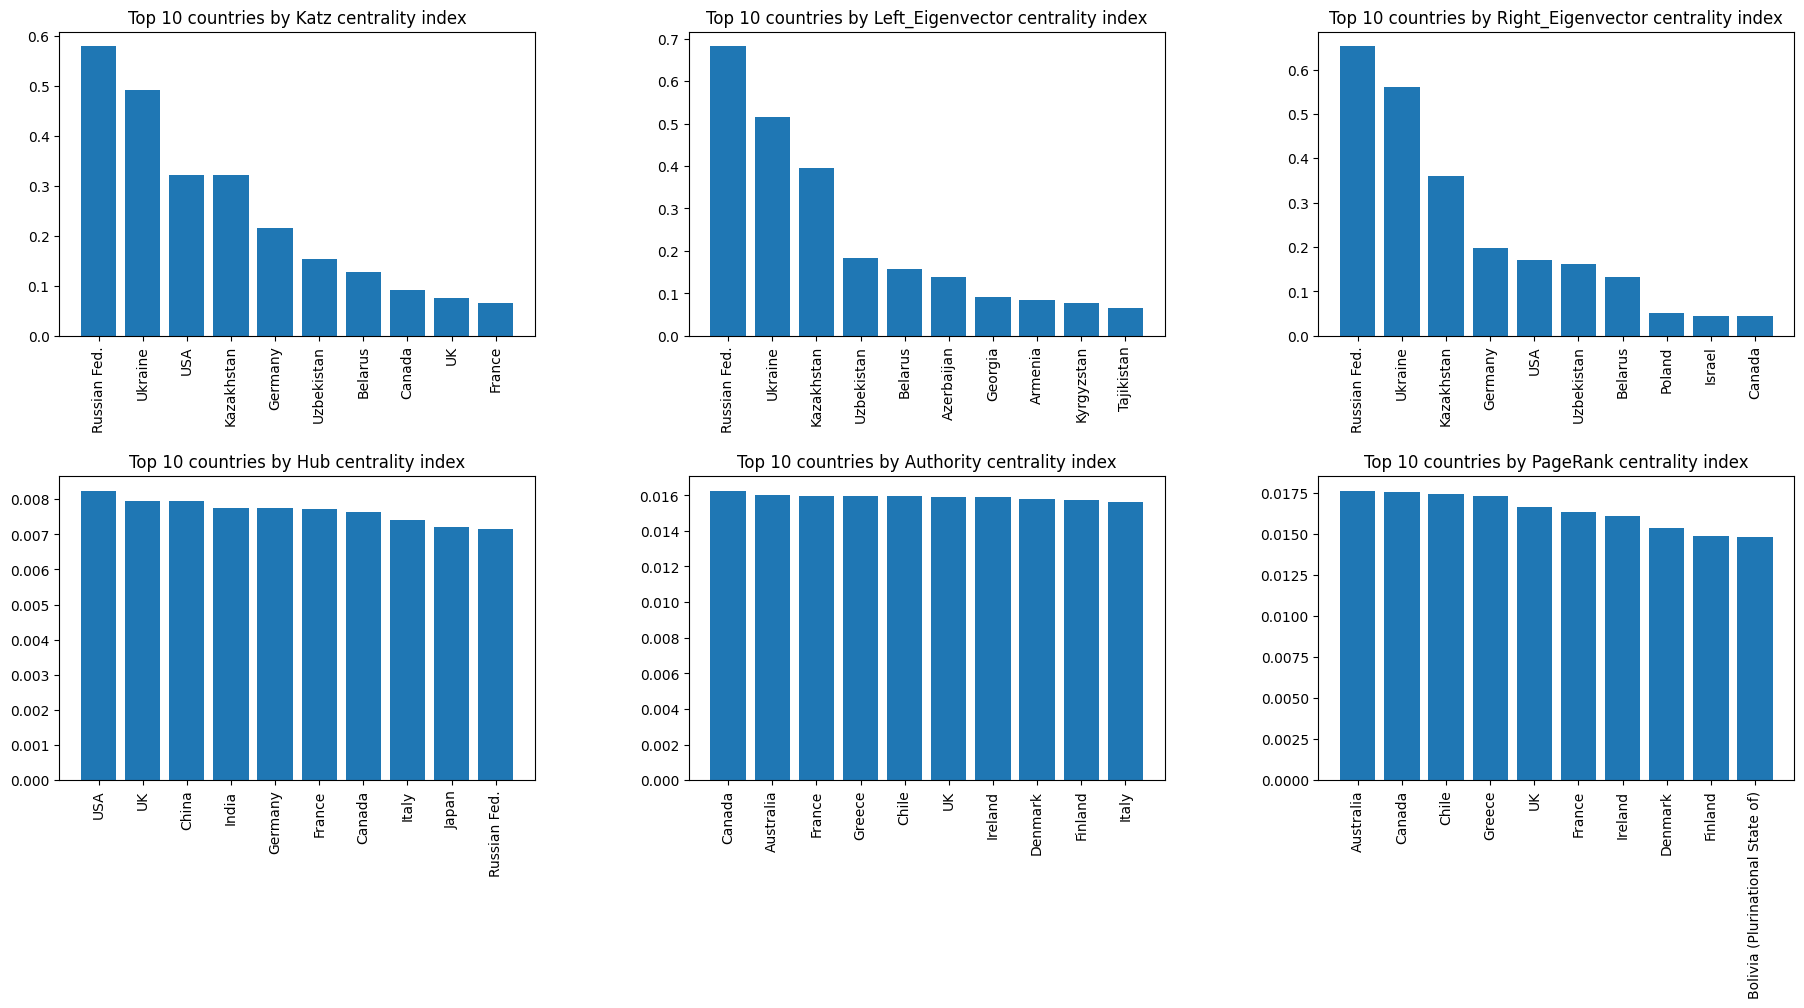

In [186]:
fig, subp = plt.subplots(math.ceil(len(sp_indices) / 3), 3, figsize = (20, 10))
fig.tight_layout(pad = 8.0)
for idx, key in enumerate(sp_indices.keys()):
    display_top(g, list(sp_indices[key].items()), 10, ax = subp[math.floor(idx / 3)][idx % 3], title = f"Top 10 countries by {key} centrality index")
plt.show()

### Overview

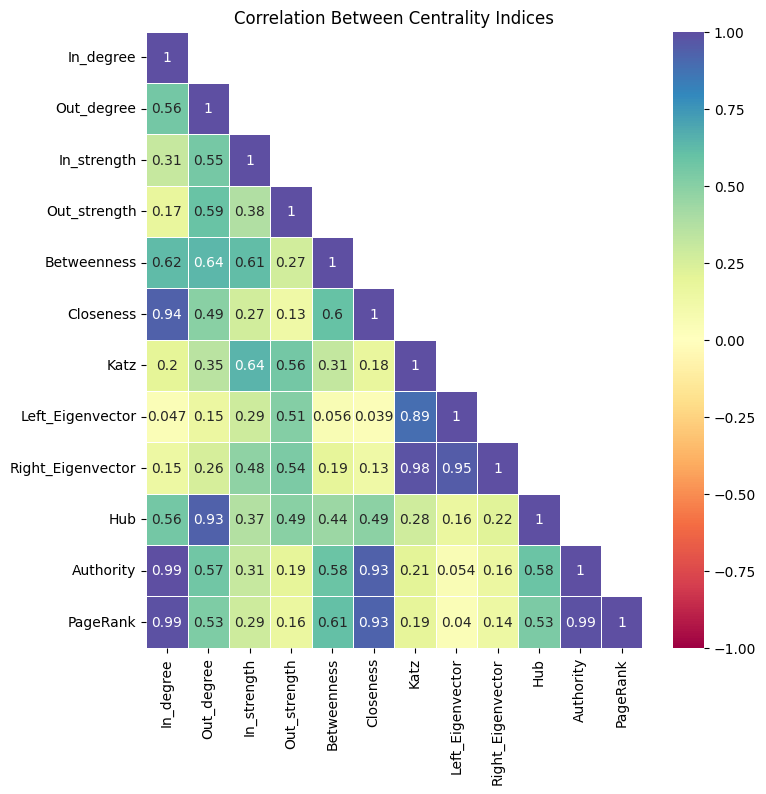

In [187]:
centralities_df = pd.DataFrame(centralities)
corr_matrix = centralities_df.corr(method = "pearson")
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
np.fill_diagonal(mask, False)
plt.figure(figsize = (8, 8))
sns.heatmap(corr_matrix, annot = True, cmap = sns.color_palette("Spectral", as_cmap = True), vmin = -1, vmax = 1, linewidths = 0.5, mask = mask)
plt.title('Correlation Between Centrality Indices')
plt.show()

## Scale free

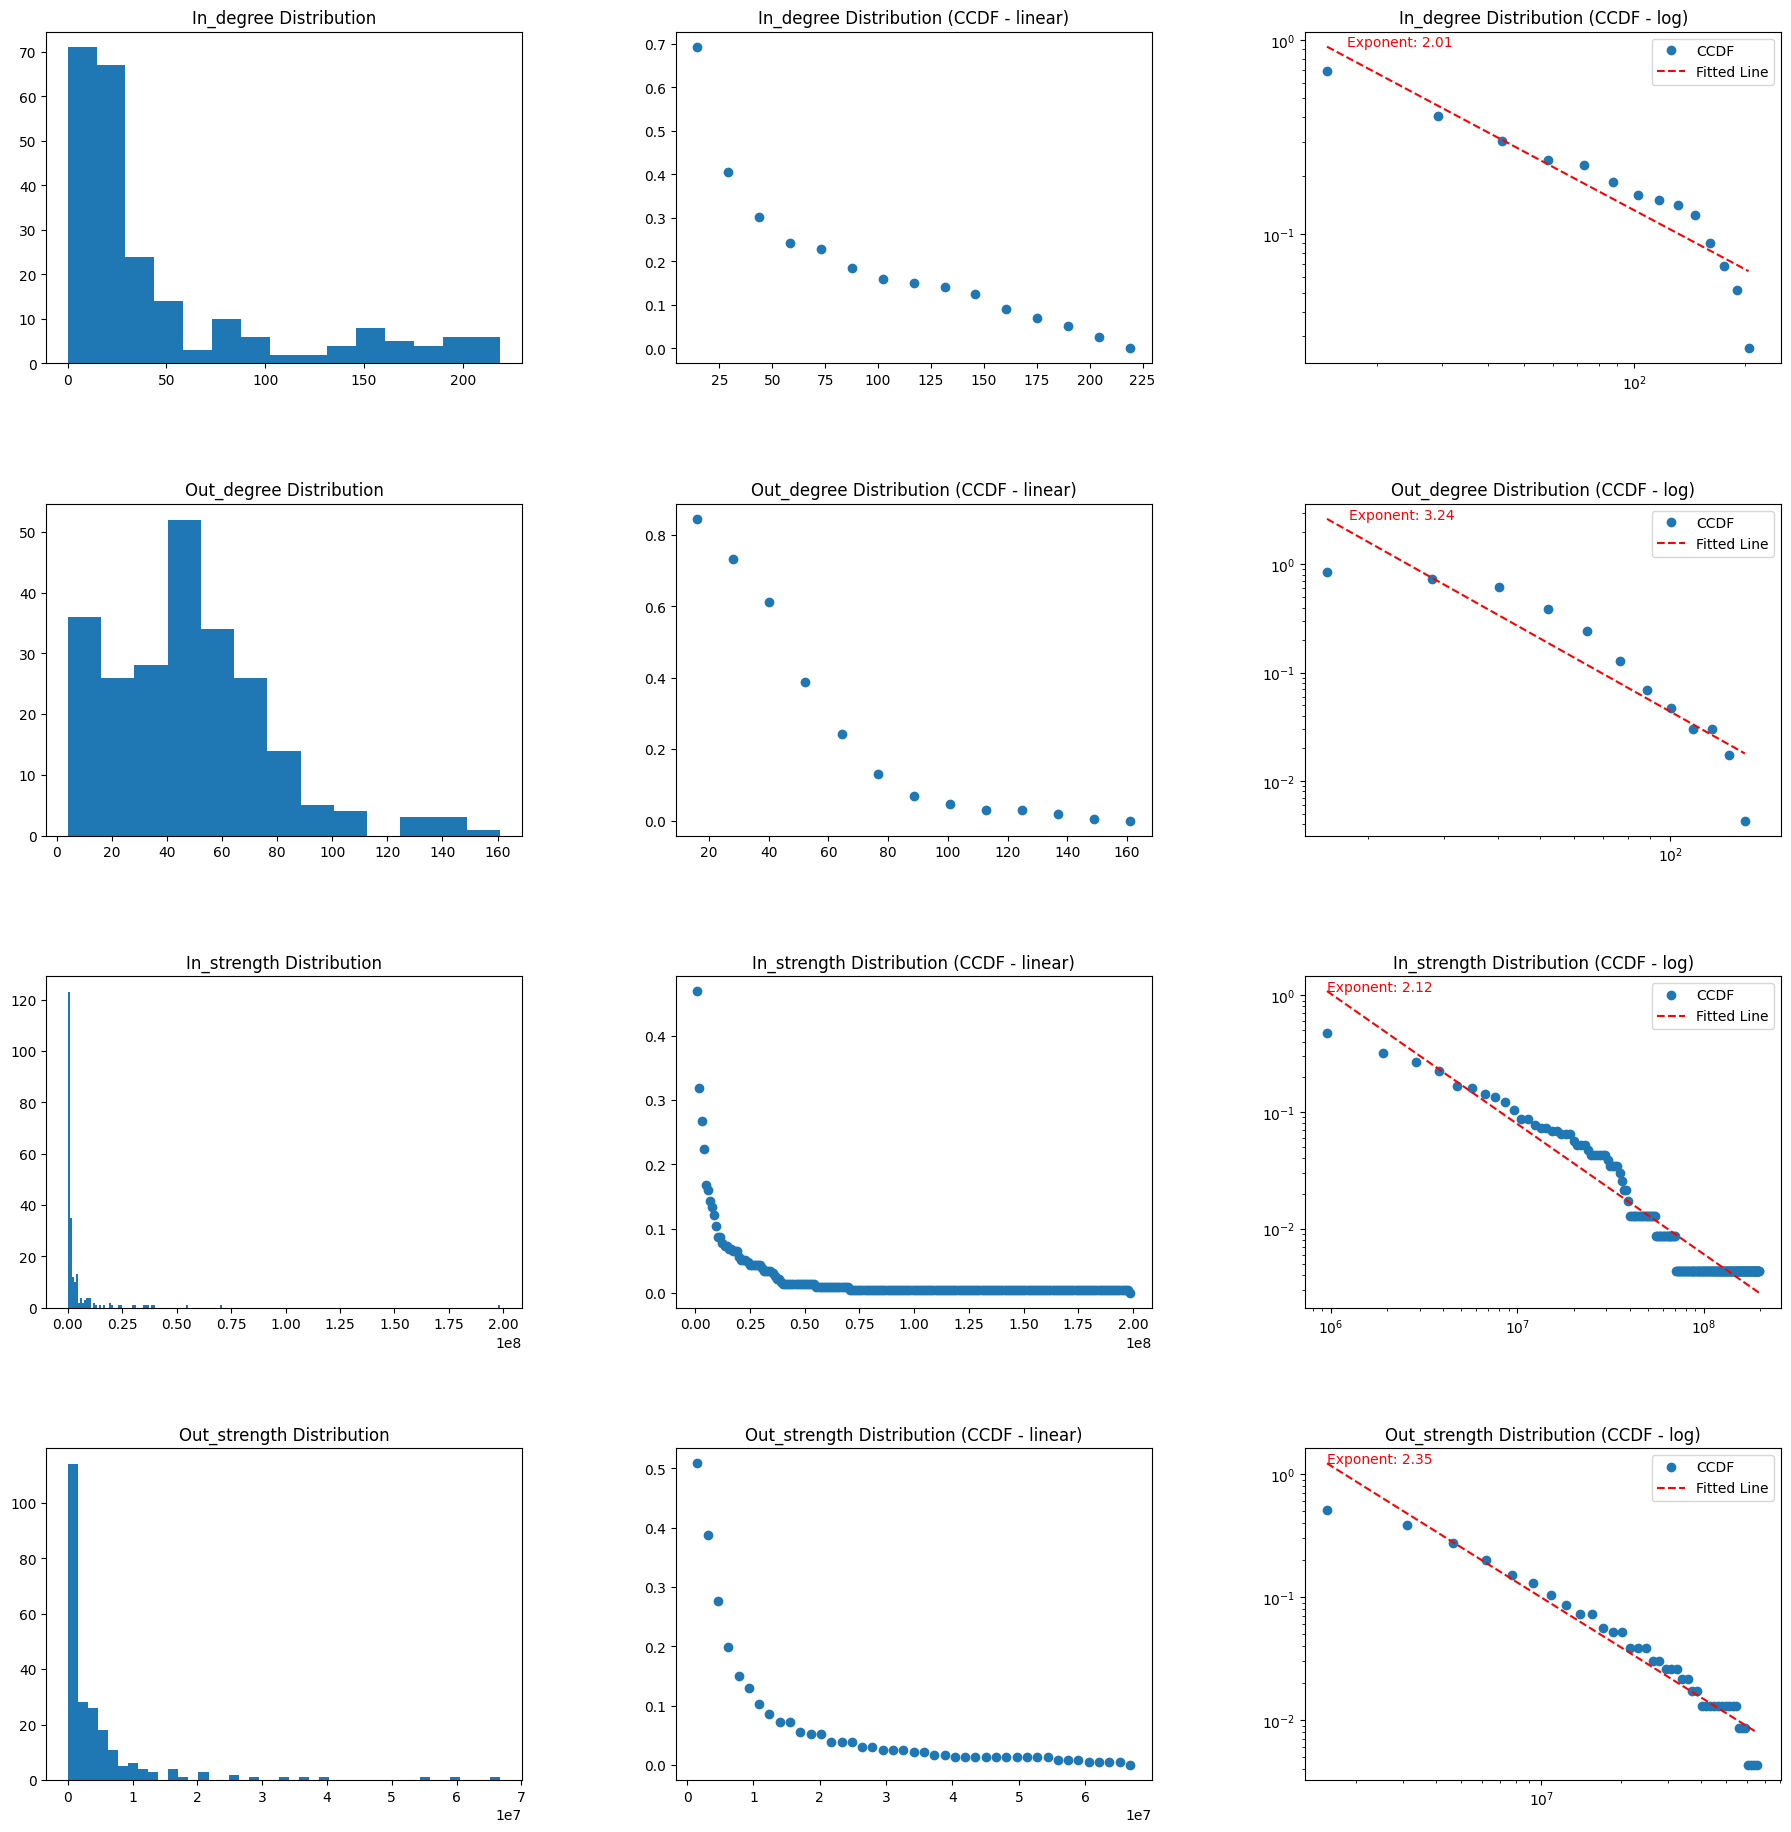

In [189]:
fig, subp2 = plt.subplots(4, 3, figsize = (20, 20))
fig.tight_layout(pad = 8.0)
for idx, key in enumerate(list(centralities.keys())[:4]):
    vals = list(centralities[key].values())
    counts, bins, _ = subp2[idx][0].hist(vals, bins = "auto")
    subp2[idx][0].set(title=f'{key} Distribution')
    cdf = np.cumsum(counts) / np.sum(counts)
    ccdf = 1 - cdf
    subp2[idx][1].plot(bins[1:], ccdf, marker = 'o', linestyle = 'none')
    subp2[idx][1].set(title = f'{key} Distribution (CCDF - linear)')
    non_zero_indices = ccdf > 0
    log_bins = np.log10(bins[1:])[non_zero_indices]
    log_ccdf = np.log10(ccdf)[non_zero_indices]
    model = LinearRegression().fit(log_bins.reshape(-1, 1), log_ccdf)
    slope = model.coef_[0]
    subp2[idx][2].loglog(bins[1:], ccdf, label = 'CCDF', marker = 'o', linestyle = 'none')
    fitted_line = 10 ** model.predict(log_bins.reshape(-1, 1))
    subp2[idx][2].loglog(bins[1:][non_zero_indices], fitted_line, label = 'Fitted Line', linestyle = '--', color = 'red')
    subp2[idx][2].text(bins[1:][non_zero_indices][0] + 2, fitted_line[0], f'Exponent: {1 - slope:.2f}', fontsize = 10, color = 'red')
    
    subp2[idx][2].set(title = f'{key} Distribution (CCDF - log)')
    subp2[idx][2].legend()

plt.show()

## Topological Indices

In [190]:
centralities_2d = np.array([list(centrality.values()) for centrality in centralities.values()])

topological_df = pd.DataFrame({
    "Centrality": centralities.keys(),
    "Average": np.average(centralities_2d, axis = 1), 
    "Minimum": np.min(centralities_2d, axis = 1),
    "Maximum": np.max(centralities_2d, axis = 1)
})
topological_df[['Average', 'Minimum', 'Maximum']] = topological_df[['Average', 'Minimum', 'Maximum']].map(lambda x: f"{x:.5f}")
topological_df

,Centrality,Average,Minimum,Maximum
0,In_degree,48.39655,0.00000,219.00000
1,Out_degree,48.39655,4.00000,161.00000
2,In_strength,4696482.00000,0.00000,198572669.00000
3,Out_strength,4696482.00000,591.00000,66732561.00000
4,Betweenness,0.00389,0.00000,0.09051
5,Closeness,0.54805,0.00000,0.95062
6,Katz,0.02990,0.01564,0.58016
7,Left_Eigenvector,0.01186,0.00000,0.68295
8,Right_Eigenvector,0.01283,0.00000,0.65283
9,Hub,0.00431,0.00029,0.00825


## Clustering

In [191]:
def watts_strogatz_coeff(g):
    return np.mean(list(nx.clustering(g).values()))


In [192]:
print("Watts - Strogatz clustering coefficient:", watts_strogatz_coeff(g))
print("Newman clustering coefficient:", nx.transitivity(g))


Watts - Strogatz clustering coefficient: 0.6364794780726611
Newman clustering coefficient: 0.6201219969500762


## Assortativity

In [193]:
print("Assortativity based on attribute \"sub_region\":", nx.attribute_assortativity_coefficient(g, attribute = "sub_region"))
print("Assortativity based on attribute \"region\":", nx.attribute_assortativity_coefficient(g, attribute = "region"))
print("(Weighted) Degree Assortativity:", nx.degree_assortativity_coefficient(g, weight = "migration_total"))
print("(Weighted) Pearson Correlation:", nx.degree_pearson_correlation_coefficient(g, weight = "migration_total"))

Assortativity based on attribute "sub_region": 0.08721544561081289
Assortativity based on attribute "region": 0.17446095492558927
(Weighted) Degree Assortativity: -0.034517956075316956
(Weighted) Pearson Correlation: -0.03451795607531669


## K-cores

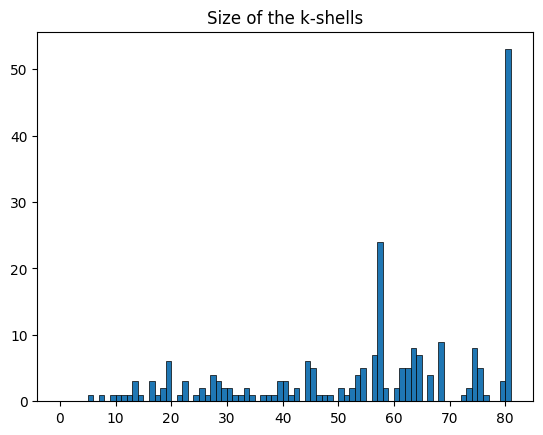

The degeneracy index of the graph is 81


In [194]:
k_cores = nx.core_number(g)
degeneracy = max(k_cores.values())
plt.hist(k_cores.values(), bins = range(degeneracy + 1), edgecolor = 'black', linewidth = 0.5)
plt.title("Size of the k-shells")
plt.show()
print("The degeneracy index of the graph is", degeneracy)


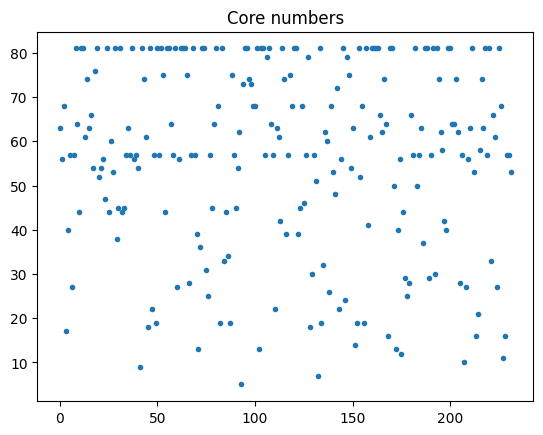

In [195]:
plt.plot(k_cores.keys(), k_cores.values(), linestyle = "none", marker = ".")
plt.title("Core numbers")
plt.show()

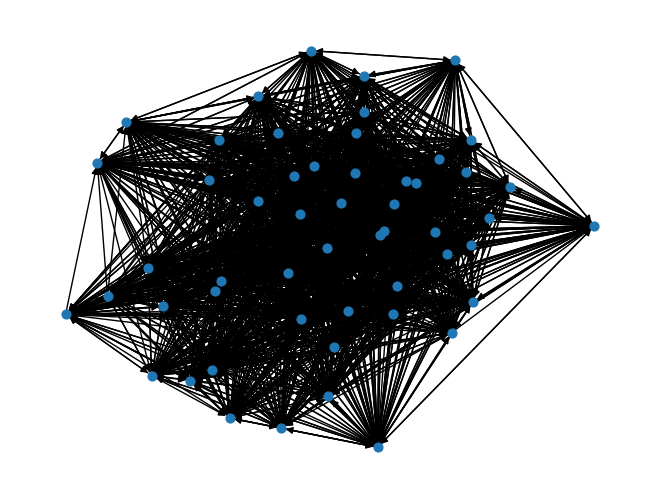

In [196]:
nth_core = nx.k_core(g, degeneracy)
nx.draw(nth_core, with_labels = False, node_size = 40, pos = nx.spring_layout(g, seed = NET_SEED))
plt.show()

## Random Network

In [197]:
def analyze_rn(rn):
    nx.draw(rn, with_labels = False, node_size = 40, pos = nx.spring_layout(g, seed = NET_SEED))

    degs = dict(rn.in_degree())
    fig, subp2 = plt.subplots(1, 3, figsize = (20, 5))
    fig.tight_layout(pad = 8.0)

    counts, bins, _ = subp2[0].hist(list(degs.values()), bins = "auto")
    subp2[0].set(title=f'In-degree Distribution')

    cdf = np.cumsum(counts) / np.sum(counts)
    ccdf = 1 - cdf
    subp2[1].plot(bins[1:], ccdf, marker = 'o', linestyle = 'none')
    subp2[1].set(title = f'In-degree Distribution (CCDF - linear)')

    non_zero_indices = ccdf > 0
    log_bins = np.log10(bins[1:])[non_zero_indices]
    log_ccdf = np.log10(ccdf)[non_zero_indices]
    model = LinearRegression().fit(log_bins.reshape(-1, 1), log_ccdf)
    slope = model.coef_[0]
    subp2[2].loglog(bins[1:], ccdf, label = 'CCDF', marker = 'o', linestyle = 'none')
    fitted_line = 10 ** model.predict(log_bins.reshape(-1, 1))
    subp2[2].loglog(bins[1:][non_zero_indices], fitted_line, label = 'Fitted Line', linestyle = '--', color = 'red')
    subp2[2].text(bins[1:][non_zero_indices][0] + 2, fitted_line[0], f'Exponent: {1 - slope:.2f}', fontsize = 10, color = 'red')
    subp2[2].set(title = f'In-degree Distribution (CCDF - log)')
    subp2[2].legend()

    plt.show()

    print("Watts - Strogatz clustering coefficient:", watts_strogatz_coeff(rn))
    print("Newman clustering coefficient:", nx.transitivity(rn))
    print("Density:", nx.density(rn))


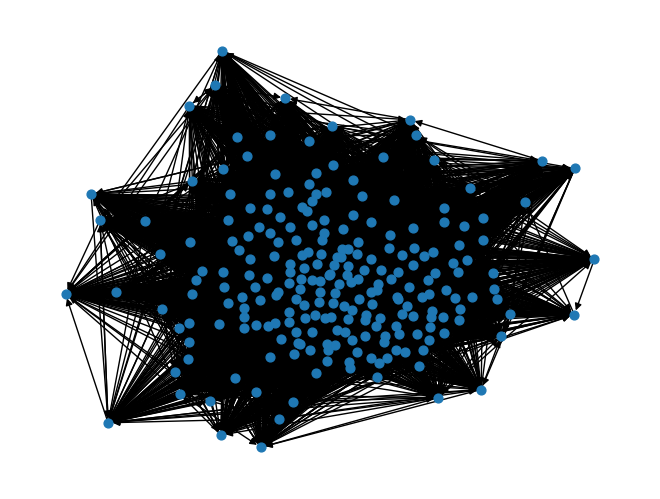

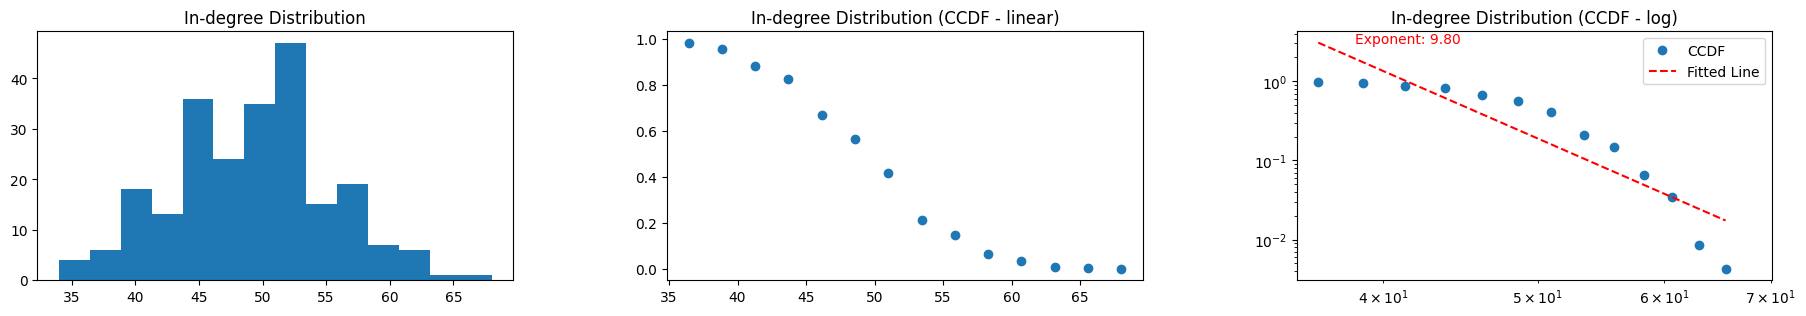

Watts - Strogatz clustering coefficient: 0.21212984841238244
Newman clustering coefficient: 0.21208423813721486
Density: 0.21281161367368265


In [198]:
ER = nx.erdos_renyi_graph(nn, density, seed = NET_SEED, directed = True)
analyze_rn(ER)

## Meso-scale structures

### Visual inspection

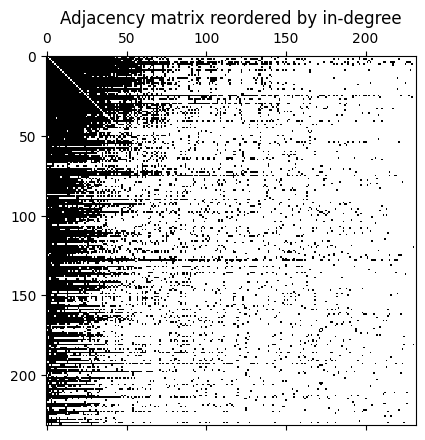

In [209]:
sorted_ind = sorted(g.nodes, key = centralities["In_degree"].get, reverse = True)
B = adj_matrix[np.ix_(sorted_ind, sorted_ind)]
plt.spy(B.todense())
plt.title("Adjacency matrix reordered by in-degree")
plt.show()

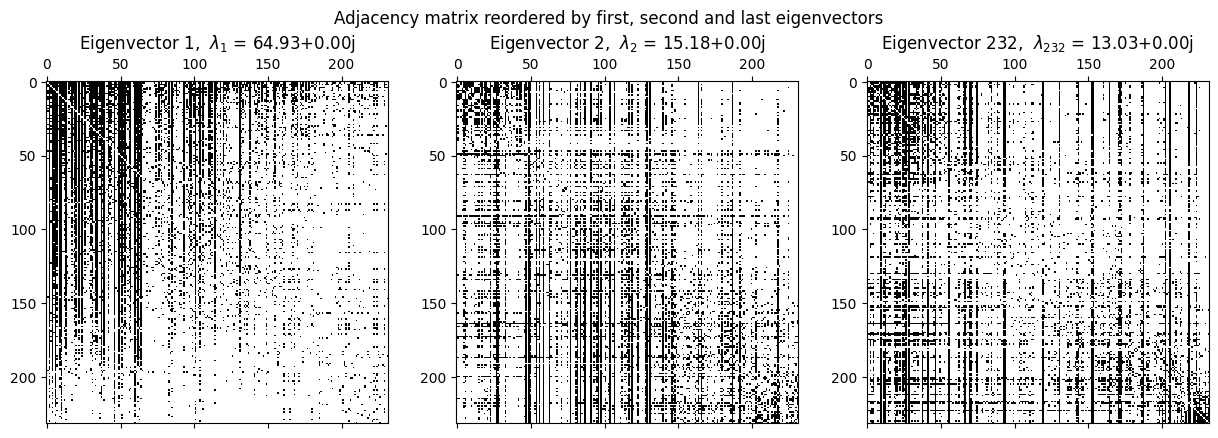

In [214]:
eigenvalues, eigenvectors = np.linalg.eig(adj_matrix.todense())

sorted_eigenpairs = [(eigenvectors[:, i], eigenvalues[i]) for i in np.argsort(eigenvalues)[::-1]]

fig, axes = plt.subplots(1, 3, figsize = (15, 5))

eigenvector_labels = {0: "1", 1: "2", 2: str(nn)}

def format_eigenvalue_label(index):
    return r'$\lambda_{' + index + '}$'

for index, ax in enumerate(axes):
    if index in eigenvector_labels:

        sorted_nodes = sorted(g.nodes, key = lambda node: sorted_eigenpairs[index][0][node])
        reordered_matrix = adj_matrix[np.ix_(sorted_nodes, sorted_nodes)]

        ax.spy(reordered_matrix.todense())

        eigenvector_number = eigenvector_labels[index]
        eigenvalue = sorted_eigenpairs[index][1]
        ax.set_title(f"Eigenvector {eigenvector_number},  {format_eigenvalue_label(eigenvector_number)} = {eigenvalue:.2f}")
fig.suptitle("Adjacency matrix reordered by first, second and last eigenvectors")
plt.show()

### Louvain method and modularity

In [201]:
louvain_unweighted = nx.community.louvain_communities(g.to_undirected(), seed = NET_SEED)
louvain_weighted = nx.community.louvain_communities(g.to_undirected(), weight = "migration_total", seed = NET_SEED)

modularity_unweighted = nx.community.modularity(g, louvain_unweighted)
modularity_weighted = nx.community.modularity(g, louvain_weighted)

print("Communities detected using Louvain method (unweighted):", len(louvain_unweighted))
print("Communities detected using Louvain method (weighted):", len(louvain_weighted))

print("Modularity (unweighted):", modularity_unweighted)
print("Modularity (weighted):", modularity_weighted)

Communities detected using Louvain method (unweighted): 4
Communities detected using Louvain method (weighted): 11
Modularity (unweighted): 0.1619138924280728
Modularity (weighted): 0.08854359089298994


In [202]:
def communities_to_colors(l):
    unique_communities = set(range(len(l)))
    color_map = {community: plt.cm.tab20(i) for i, community in enumerate(unique_communities)}
    return color_map, {node: color_map[group_index] for group_index, node_set in enumerate(l) for node in node_set}

In [203]:
ucmap, luc = communities_to_colors(louvain_unweighted)
wcmap, luwc = communities_to_colors(louvain_weighted)

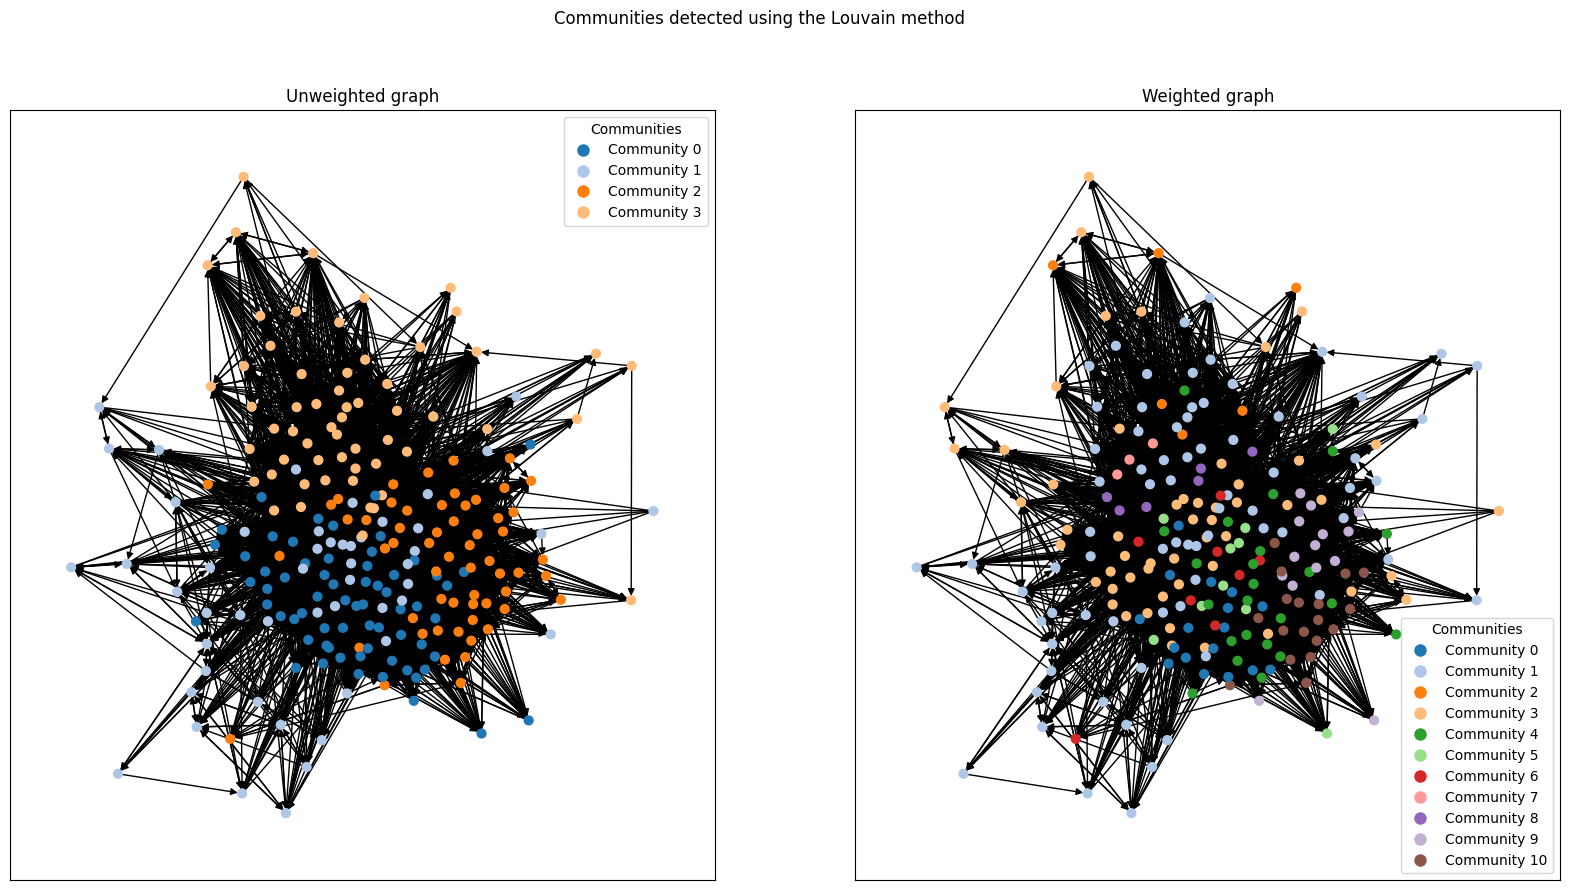

In [120]:
fig, axs = plt.subplots(1, 2, figsize = (20, 10))
nx.draw_networkx(g, node_color = [luc[node] for node in g.nodes()], with_labels = False, node_size = 40, pos = nx.spring_layout(g, seed = NET_SEED), ax = axs[0])
region_patches = [plt.Line2D([0], [0], marker = 'o', color = 'w', label = f"Community {community}",
                          markerfacecolor = color, markersize = 10)
                     for community, color in ucmap.items()]
axs[0].legend(handles = region_patches, title = "Communities")
nx.draw_networkx(g, node_color = [luwc[node] for node in g.nodes()], with_labels = False, node_size = 40, pos = nx.spring_layout(g, seed = NET_SEED), ax = axs[1])
region_patches = [plt.Line2D([0], [0], marker = 'o', color = 'w', label = f"Community {community}",
                          markerfacecolor = color, markersize = 10)
                     for community, color in wcmap.items()]
axs[1].legend(handles = region_patches, title = "Communities")
fig.suptitle("Communities detected using the Louvain method")
axs[0].set_title("Unweighted graph")
axs[1].set_title("Weighted graph")
plt.show()

### Partitions comparison

In [204]:
def build_comparing_matrix(g, subsets):
    number_of_nodes = g.number_of_nodes()
    M = np.zeros((number_of_nodes, number_of_nodes))
    for subset in subsets:
        for (i, j) in itertools.combinations(subset, 2):
            M[i, j] = 1
            M[j, i] = 1
        
    return M

In [205]:
nodes_region = nx.get_node_attributes(g, 'region')
regions_subsets = [{node for node, region in nodes_region.items() if region == key} for key in unique_regions]

In [206]:
matrix = build_comparing_matrix(g, louvain_unweighted)
matrix2 = build_comparing_matrix(g, regions_subsets)
matrix3 = build_comparing_matrix(g, louvain_weighted)

In [207]:
vector = matrix[np.triu_indices_from(matrix, k = 1)]
vector2 = matrix2[np.triu_indices_from(matrix2, k = 1)]
vector3 = matrix3[np.triu_indices_from(matrix3, k = 1)]

In [208]:
df = pd.DataFrame({
    "Comparison": ["Louvain (unweighed) - Regions", "Louvain (weighted) - Regions"],
    "Pearson coefficient": [np.corrcoef(vector2, vector)[0, 1], np.corrcoef(vector2, vector3)[0, 1]],
    "Rand coefficient": [rand_score(vector2, vector), rand_score(vector2, vector3)]
    })
df

,Comparison,Pearson coefficient,Rand coefficient
0,Louvain (unweighed) - Regions,0.441675,0.683914
1,Louvain (weighted) - Regions,0.162978,0.616550
